In [75]:
using QuantumBayesian
using PyPlot
using Pkg
using SparseArrays

# Transmon Qubit and Resonator Test

**Justin Dressel**, 12/8/2016 <br />
*Institute for Quantum Studies, Chapman University*

To benchmark performance for large qubit systems, we test the deterministic evolution of a transmon and resonator system subject to intrinsic (Markovian) resonator decay.

## Transmon and Qubit Definitions

Define a joint system of a transmon (with 5 energy levels) and a resonator (with 30 energy levels).

In [204]:
q = osc(2, "Transmon");
r = osc(2, "Transmon");
s = q ⊗ r
ground(s)

DimensionMismatch: DimensionMismatch("new dimensions (2, 2) must be consistent with array size 2")

In [202]:
# Using (i) index for a 1D (vector) representation
Base.@propagate_inbounds Base.getindex(A::QFactor, i::Int) =
    sparsevec([i], [QComp(1)], length(A))
# Using (i,j) indices for the 2D representation
Base.@propagate_inbounds Base.getindex(A::QFactor, i::Int, j::Int) =
    sparse([i], [j], [QComp(1)], length(A), length(A))

# Using (i1,j1,k1,...,i2,j2,k2,...) indices for subsystem representation
@inline Base.@propagate_inbounds function Base.getindex(A::QSpace, inds::Int...)
    l = length(size(A))
    fs = factors(A)
    if length(inds) == l  # 1D (vector)
        ⊗([f[i] for (f,i) in zip(fs,inds)]...)
    elseif length(inds) == 2*l  # 2D (matrix)
        subinds = reshape(collect(inds), l, 2)
        ⊗([f[subinds[i,:]...] for (i,f) in enumerate(fs)]...)
    else
        error("Incorrect indexing.")
    end
end

For convenience, define a qubit matrix element `qel(i,j)`$ = \lvert i\rangle\langle j\rvert \otimes \mathbb{1}$:

In [32]:
qel(i,j) = lift(s, q(i,j), 1);

Define the lowering operator for the resonator using standard notation, as well as the number operator.

In [33]:
a = s("id");
n = a' * a;

Define relevant constants typical of superconducting qubit experiments performed at UCSB [modeled after "Qubit 1" in Nature **519**, 66-69 (2015)]. The qubit frequency is defined by the different of the first two energy levels of the transmon: $\omega_q = (E_1 - E_0)/\hbar$. The anharmonicity is defined as the discrepancy in energy of the next pair: $\eta = \omega_q - (E_2 - E_1)/\hbar$.  The approximate dispersive shift $\chi$ and Lamb shift $\lambda$ are computed in the Appendix of Physical Review A **92**, 012325 (2015):
$$ \begin{aligned}
\chi &= -\frac{\eta\,g^2}{(\omega_q - \omega_r)^2} \\
\lambda &= -\frac{g^2}{\omega_q-\omega_r}
\end{aligned} $$

The needed drive amplitude is computed from the steady-state photon number $\bar{n} = |\alpha_{\rm ss}|^2$, derived from the classical resonator equation: $$\dot{\alpha_{\rm ss}} = -i(\omega_r + \lambda + \chi - \omega_d)\,\alpha_{\rm ss} - (\kappa/2)\,\alpha_{\rm ss} - i \varepsilon \equiv 0$$.

In [34]:
# Bare parameters
ωq = (2π)*5.93             # qubit frequency (GHz): energy gap between |0⟩ and |1⟩ levels
ωr = (2π)*6.626            # resonator frequency (GHz), detuned from the qubit frequency in dispersive regime
η  = (2π)*0.216            # qubit anharmonicity  (GHz)
g  = (2π)*0.128            # qubit-resonator coupling strength (GHz)
ωd = ωr                    # microwave drive frequency
κ  = (2π)/69               # resonator decay rate

# Compute effective frequency shifts
χ  = -η*g^2 / (ωq - ωr)^2  # resonator dispersive frequency shift: 2χ is net change in ωq
λ  = -g^2 / (ωq - ωr)      # Lamb shift of resonator frequency
ωreff = ωr + λ + χ         # effective (ground-state) resonator frequency including Lamb and dispersive shift

# Set pump strength
nmax = 4                   # target photon number at steady state
ɛ  = sqrt(nmax*((ωreff-ωd)^2 + (κ/2)^2))  # microwave drive amplitude;

Note that we working in the rotating frequency of the pump, which is set to the bare frequency of the resonator. However, the qubit-induced Lamb shift and dispersive shift of the resonator frequency will cause residual oscillations with the following period:

In [35]:
# Effective residual resonator rotation period, expected (ns)
(2π)/(ωreff - ωd)

61.5966796874981

The so-called "critical photon number" is the scale at which nonlinear effects should become relevant for the qubit-resonator evolution (i.e., when the qubit and resonator should hybridize appreciably).

In [36]:
ncrit = (ωq - ωreff)^2 / (4g^2)   # photon number threshold before nonlinear effects should appear

7.740450809750334

Define the Hamiltonian for coherent evolution:
$$ \begin{aligned}
H_q &= \sum_{k=0}^{d-1} \left[k(\omega_q - \omega_d) - k(k-1)\eta /2\right]\, \lvert k \rangle \langle k\rvert \\
H_r &= (\omega_r - \omega_d)\,a^\dagger a \\
H_p &= \varepsilon(a + a^\dagger) \\
H_i &= g\sum_{k=1}^{d-1}\sqrt{k}\left[a\,\lvert k \rangle \langle k-1\rvert + a^\dagger\,\lvert k-1 \rangle \langle k\rvert \right] \\
H_{\rm tot} &= H_q + H_r + H_p + H_i
\end{aligned}$$

Also define the dissipative collapse operator for the resonator decay:
$$ L_r = \sqrt{\frac{\kappa}{2}}\,a$$

In [47]:
# Hamiltonian
#  Qubit free evolution
Hq = sum((k*(ωq - ωd) - k*(k+1)*η/2).*qel(k,k) for k in 0:(length(q)-1))
#  Resonator free evolution
Hr = (ωr - ωd).* n
#  Microwave pump
Hp = ɛ .* (a .+ a')
#  Qubit-resonator interaction (Jaynes-Cummings-type interaction)
Hint = sum((sqrt(k)*g).*(a * qel(k,k-1) + a' * qel(k-1,k)) for k in 1:(length(q)-1));
#   Total Hamiltonian
H = Hq + Hr + Hp + Hint;

# Dissipative collapse operator (Lindblad Markovian decay)
Lr = sqrt(κ/2).*a;

Illustrate the banded structure of the Jaynes-Cummings coupling in the total Hamiltonian.

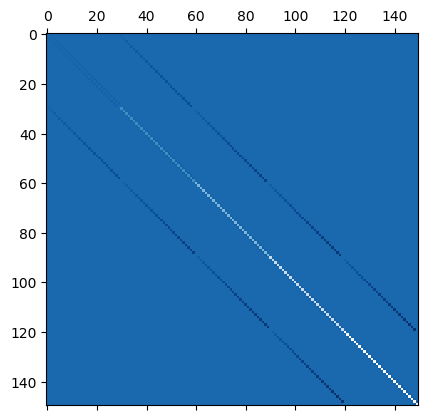

In [38]:
matshow(real(H); cmap=:Blues)
show()

## Simulation and Plotting Code

Hamiltonian evolution using a pure state (wavefunction) as a benchmark for efficiency. This solves the time-independent Schrodinger equation $i\hbar \partial_t |\psi\rangle = H |\psi\rangle$ by exact matrix exponentiation.

In [57]:
function solveψ(Δt=0.1)
    meana(ψ) = expectvec(ψ, a)
    pop(ψ) = real(expectvec(ψ, n))
    p0(ψ) = real(expectvec(ψ, qel(0,0)))
    p1(ψ) = real(expectvec(ψ, qel(1,1)))
    p2(ψ) = real(expectvec(ψ, qel(2,2)))
    t = trajectory(ham(Δt, H, ket=true), groundvec(s), (0.0, 200.0), meana, pop, p0, p1, p2, dt=Δt)
end;

Mixed state master equation evolution that includes decay. This solves the Lindblad master equation $\partial_t \rho = (1/i\hbar)[H,\,\rho] + L_r \rho L_r^\dagger - \{L_r^\dagger L_r,\, \rho \}/2$ using one of several methods. Method 1: by unraveling the evolution into independent jump and no-jump evolutions. Method 2: explicit 4th-order Runge-Kutta integration.

In [40]:
function solveρ(step, Δt=0.1)
    meana(ρ) = expect(ρ, a)
    pop(ρ) = real(expect(ρ, n))
    p0(ρ) = real(expect(ρ, qel(0,0)))
    p1(ρ) = real(expect(ρ, qel(1,1)))
    p2(ρ) = real(expect(ρ, qel(2,2)))
    t = trajectory(step(Δt, H, clist=[Lr]), ground(s), (0.0, 200.0), meana, pop, p0, p1, p2, dt=Δt)
end;

Super-operator method for exact matrix exponential of Lindblad evolution (requires considerably more memory). This solves the same Lindblad master equation as above in super-operator space by exact matrix exponentiation.

In [41]:
function solveρsuper(Δt=0.1)
    meana(ρ) = expect(unsuperket(ρ), a)
    pop(ρ) = real(expect(unsuperket(ρ), n))
    p0(ρ) = real(expect(unsuperket(ρ), qel(0,0)))
    p1(ρ) = real(expect(unsuperket(ρ), qel(1,1)))
    p2(ρ) = real(expect(unsuperket(ρ), qel(2,2)))
    t = trajectory(slind(Δt, H, clist=[Lr]), superket(ground(s)), (0.0, 200.0), meana, pop, p0, p1, p2, dt=Δt)
end;

Matplotlib code for plotting both the resonator dynamics and the qubit populations nicely.

In [42]:
function plotsolution(t)
    as = t[1]
    ns = t[2]
    p0s = t[3]
    p1s = t[4]
    p2s = t[5]
    
    figure(1)
    p1 = plot(real(as), imag(as), label=L"$\alpha(t)$")
    ax = gca()
    ax.set_ylim([-2.1,2.1])
    ax.set_xlim([-4.5,0.5])
    xlabel(L"Re$\alpha$")
    ylabel(L"Im$\alpha$")
    title("Classical Resonator amplitude")
    legend()
    grid()
    show()
    
    figure(2)
    p2 = plot(ns.t, ns)
    xlabel(L"$t$ (ns)")
    ylabel(L"$n(t)$")
    title("Photon Number vs. Time")
    grid()
    show()

    figure(3)
    ax = gca()
    ax.set_ylim([0,1.05])
    p2 = plot(p0s.t, p0s, label=L"$P_0$")
    plot(p1s.t, p1s, label=L"$P_1$")
    plot(p2s.t, p2s, label=L"$P_2$")
    plot(p0s.t, p0s.+p1s.+p2s, label=L"$P_{\rm tot}$")
    xlabel(L"$t$ (ns)")
    ylabel("Probability")
    title("Qubit Populations vs. Time")
    grid()
    legend()
    show()
end;

## Simulation Results

### Benchmark Hamiltonian pure state evolution

In [45]:
@time t = solveψ()
plotsolution(t);

ErrorException: Incorrect indexing.

### Jump/no-jump Lindblad decay evolution

In [101]:
@time t = solveρ(lind)
plotsolution(t);

DimensionMismatch: DimensionMismatch("matrix A has dimensions (150,1), matrix B has dimensions (150,150)")

### Explicit 4th-order Runge-Kutta integration

In [26]:
@time t = solveρ(lind_rk4)
plotsolution(t);

LoadError: DimensionMismatch("matrix A has dimensions (150,1), matrix B has dimensions (150,150)")

In [27]:
# Try a factor of 10 smaller time step
@time t = solveρ(lind_rk4, 0.01)
plotsolution(t);

LoadError: DimensionMismatch("matrix A has dimensions (150,1), matrix B has dimensions (150,150)")

### Super-operator Lindblad method

In [28]:
@time t = solveρsuper()
plotsolution(t);

LoadError: InterruptException:

## Conclusions

The pure state evolution is several orders of magnitude faster, since the matrix exponential can still be performed in memory. (Note that the slight decay observed in the pure state case is due to numerical error being accumulated by the state space truncation at larger photon number, which can be fixed by further increasing the size of the state space. This was not done here since the focus was on the dissipative part of the evolution that keeps the photon number better-bounded.) 

The jump/no-jump method produces the correct solution to good precision, even with course time steps of $\Delta t = 0.1$ns. The explicit Runge-Kutta requires substantially smaller time steps to even converge to the correct solution, and is already half as fast as the jump/no-jump method when using comparable time step size. Even decreasing the time steps by a factor of 10 was not sufficient to prevent eventual accumulation of catastrophic imprecision, making run-time untenable. The super-operator method would be considerably faster since it is an exact matrix exponential like the Hamiltonian case, but it fails in the case of large quantum dimensionality due to the excessive memory consumption required to compute that exponential. 

Therefore, given realistic CPU and memory constraints on a single machine, the jump/no-jump method is clearly superior for such large dimensional systems.

## Version information

In [33]:
versioninfo()

Julia Version 1.0.0
Commit 5d4eaca0c9 (2018-08-08 20:58 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.0 (ORCJIT, haswell)


In [40]:
Pkg.installed()["QuantumBayesian"]

v"0.3.0"

In [41]:
Pkg.installed()["PyPlot"]

v"2.6.0"

In [42]:
Pkg.installed()["Interpolations"]

v"0.8.0"